In [1]:
import torch.nn as nn
import torch.nn.parallel
import random
import argparse
from network.resnet import resnet18, resnet34
from network.pointnet import PointNetCls
from torch.utils.data import DataLoader, random_split
import os
import numpy as np
# from data.cifar10_train_val_test import CIFAR10, CIFAR100
from data.cifar10_train_val_test_subset_select import CIFAR10
from data.modelnet40 import ModelNet40
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from noise import noisify_with_P, noisify_cifar10_asymmetric, noisify_cifar100_asymmetric, noisify_pairflip, noisify_modelnet40_asymmetric
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"



In [4]:
# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)


# train_props = [0.2, 0.4, 0.8, 1.0]
# # train_props = [0.6]


# for train_d_props in train_props:
#     num_epoch = 180
#     milestone = "60,120"
#     milestone = [int(x) for x in milestone.split(',')]
#     batch_size = 512

#     weight_decay = 1e-4
#     gamma = 0.5
#     lr = 0.001
#     train_val_ratio = 1.0
#     train_val_ratio0 = 0.8

#     transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])

#     transform_test = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])

#     trainset = CIFAR10(root='./data', split='train', train_ratio=train_val_ratio, download=True, transform=transform_train)
#     train_ds0, _ = random_split(trainset, [int(train_d_props*len(trainset)), len(trainset) - int(train_d_props*len(trainset))])
#     train_ds_subset, val_ds_subset = random_split(train_ds0, [int(
#         train_val_ratio0*len(train_ds0)), len(train_ds0) - int(train_val_ratio0*len(train_ds0))])

#     trainloader = torch.utils.data.DataLoader(train_ds_subset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

#     # valset = CIFAR10(root='./data', split='val', train_ratio=train_val_ratio,download=True, transform=transform_test)
#     valloader = torch.utils.data.DataLoader(val_ds_subset, batch_size=batch_size, shuffle=False, num_workers=0)

#     testset = CIFAR10(root='./data', split='test',download=True, transform=transform_test)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

#     num_classes = 10
#     in_channel = 3

#     print('train data size:', len(train_ds_subset))
#     print('validation data size:', len(val_ds_subset))
#     print('test data size:', len(testset))
#     ntrain = len(trainset)

#     y_train = trainset.get_data_labels()
#     y_train = np.array(y_train)

#     # noise_level = 0.4
#     # random_seed = 42
#     # noise_y_train, p, keep_indices = noisify_with_P(
#     #     y_train, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#     # trainset.update_corrupted_label(noise_y_train)
#     # print("apply uniform noise")

#     torch.manual_seed(77)
#     net = resnet18(in_channel=in_channel, num_classes=num_classes)
#     feature_size = 512

#     optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net = net.to(device)

#     ################################################
#     exp_lr_scheduler = lr_scheduler.MultiStepLR(
#         optimizer, milestones=milestone, gamma=gamma)

#     criterion = nn.NLLLoss()  # since the output of network is by log softmax

#     best_acc = 0
#     best_epoch = 0

#     best_accuracy = 0
#     models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"
#     unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
#     torch.manual_seed(77)
#     avg_loss = []
#     val_acc = []
#     train_acc = []
#     for epoch in range(num_epoch):  # loop over the dataset multiple times

#         running_loss = []
#         net.train()

#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             # noisy_train_dl loads in order: idx, input, label, weights, cd_y

#             inputs, labels, _, _, _ = data
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # forward + backward + optimize
#             # outputs, _ = net(inputs.to(device))
#             outputs, _ = net(inputs.to(device))
#             log_outputs = torch.log_softmax(outputs, 1)

#             loss = criterion(log_outputs, labels.long().to(device)).mean()

#             loss.backward()
#             optimizer.step()
#             running_loss.append(loss.item())
#         exp_lr_scheduler.step()
#         avg_loss.append(torch.tensor(running_loss).mean())
#         print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#             epoch, torch.tensor(running_loss).mean()))

#         if True:
#             classes = tuple([str(i) for i in unique_labels])
#             correct_pred = {classname: 0 for classname in classes}
#             total_pred = {classname: 0 for classname in classes}
#             total = 0
#             correct = 0

#             net.eval()
#             with torch.no_grad():
#                 for data in valloader:
#                     images, labels, _,_,_ = data
#                     outputs, _ = net(images.to(device))
#                     _, predictions = torch.max(outputs, dim=1)
#                     total += labels.size(0)
#                     correct += (predictions.cpu() == labels).sum().item()
#                 # collect the correct predictions for each class
#                     # for label, prediction in zip(labels, predictions):
#                     #     if label == prediction:
#                     #         correct_pred[classes[int(label)]] += 1
#                     #     total_pred[classes[int(label)]] += 1

#             # print accuracy for each class
#                 # for classname, correct_count in correct_pred.items():
#                 #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#                 #         [1]), where=total_pred[classname] != 0)
#                 #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#                 print(f'Accuracy of the network on the validation set: {100 * correct / total} %')
#                 val_acc.append(100 * correct / total)

#         if val_acc[-1] > best_accuracy:
#             best_accuracy = val_acc[-1]
#             net_path = models_path + "CIFAR10_clean"+"ds_size={train_d_props: 0.2f}".format(train_d_props=train_d_props) + ".pth"
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': net.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val-accuracy': val_acc,
#                 'train-accuracy': train_acc}, net_path)

#         net.eval()
#         classes = tuple([str(i) for i in unique_labels])
#         correct_pred = {classname: 0 for classname in classes}
#         total_pred = {classname: 0 for classname in classes}
#         total = 0
#         correct = 0
#         with torch.no_grad():
#             for data in trainloader:
#                 images, labels, _,_,_ = data
#                 outputs, _ = net(images.float().to(device))
#                 _, predictions = torch.max(outputs, dim=1)
#                 total += labels.size(0)
#                 correct += (predictions.cpu() == labels).sum().item()
#             # collect the correct predictions for each class
#                 # for label, prediction in zip(labels, predictions):
#                 #     if label == prediction:
#                 #         correct_pred[classes[int(label)]] += 1
#                 #     total_pred[classes[int(label)]] += 1

#         # print accuracy for each class
#         # for classname, correct_count in correct_pred.items():
#         #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#         #         [1]), where=total_pred[classname] != 0)
#         #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#         print(f'Accuracy of the network on the train set: {100 * correct / total} %')
#         train_acc.append(100 * correct / total)

#     print('Finished Training')

#     net_path = models_path + "CIFAR10_clean"+"ds_size={train_d_props: 0.2f}".format(train_d_props=train_d_props) + ".pth"
#     best_net_dict = torch.load(net_path)
#     best_net_dict['val-accuracy'] = val_acc
#     best_net_dict['train-accuracy'] = train_acc
#     torch.save(best_net_dict, net_path)

# print('Finished Training')


Files already downloaded and verified
Files already downloaded and verified
train data size: 24000
validation data size: 6000
test data size: 10000
epoch=0,  avg_loss = 1.6518
Accuracy of the network on the validation set: 45.31666666666667 %
Accuracy of the network on the train set: 46.75 %
epoch=1,  avg_loss = 1.2522
Accuracy of the network on the validation set: 57.05 %
Accuracy of the network on the train set: 58.25 %
epoch=2,  avg_loss = 1.0460
Accuracy of the network on the validation set: 60.516666666666666 %
Accuracy of the network on the train set: 62.0125 %
epoch=3,  avg_loss = 0.9184
Accuracy of the network on the validation set: 51.5 %
Accuracy of the network on the train set: 52.65416666666667 %
epoch=4,  avg_loss = 0.7974
Accuracy of the network on the validation set: 65.06666666666666 %
Accuracy of the network on the train set: 67.0625 %
epoch=5,  avg_loss = 0.6900
Accuracy of the network on the validation set: 64.03333333333333 %
Accuracy of the network on the train set

Files already downloaded and verified
test set accuraccy: 81.62 %
test set accuraccy: 87.77 %
test set accuraccy: 91.69 %
test set accuraccy: 92.15 %


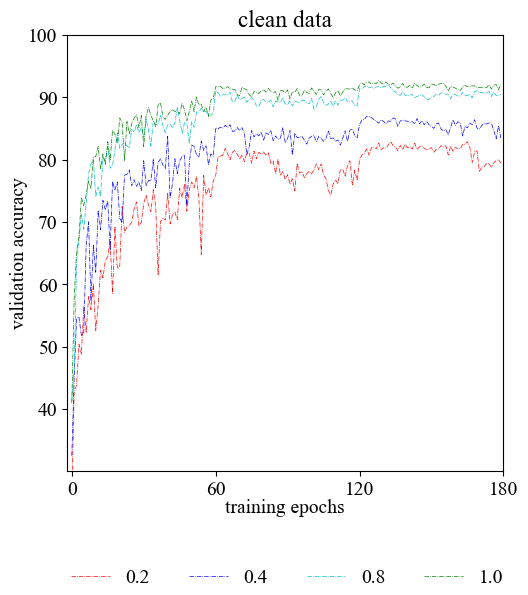

In [64]:
import pandas as pd
import matplotlib

models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"

font = {'family': 'Times New Roman',
        'size': 14}
font1 = {'family': 'Times New Roman',
         'size': 14}

matplotlib.rc('font', **font)
c = 2
line_colors = ['r', 'b', 'c', 'g']
train_props = [0.2, 0.4, 0.8, 1.0]

max_epochs = 180
fig = plt.figure(figsize=(5.5, 6.6), tight_layout=True)
axs = fig.add_subplot(1, 1, 1)

max_val_accs = np.zeros([len(train_props)])
max_test_accs = np.zeros([len(train_props)])

test_transform = transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])

testset = CIFAR10(root='./data', split='test',download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

# models_path = ""
in_channel = 3
num_classes = 10

for i in range(len(train_props)):
    train_d_props = train_props[i]
    net_path = models_path + "CIFAR10_clean"+"ds_size={train_d_props: 0.2f}".format(train_d_props=train_d_props) + ".pth"
    best_net_dict = torch.load(net_path)
    net = resnet18(in_channel=in_channel,num_classes=num_classes).to(device)
    net.load_state_dict(best_net_dict['model_state_dict'])

    classes = tuple([str(i) for i in unique_labels])
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total = 0
    correct = 0

    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels, _, _, _ = data
            outputs, _ = net(images.to(device))
            _, predictions = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predictions.cpu() == labels).sum().item()
        print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i] = 100 * correct / total

        acc_ci = best_net_dict["val-accuracy"]
        max_val_accs[i] = max(acc_ci)
        acc_ci = np.array([k/100 for k in acc_ci])
        
        # axs = fig.add_subplot(2, 2, i+1)
        
        iters = np.linspace(0, max_epochs, max_epochs, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{train_d_props:0.1f}".format(train_d_props=train_d_props)
        
        axs.plot(iters, 100*acc_ci, color=line_colors[i], linestyle="-.", label=label_str, linewidth=0.5)
        # if i != len(trust_props)-1:
        #     axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", linewidth=0.5)
        # else:
        #     axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=0.5)

    # title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    
    # axs.flatten()[i].set_title(title_str, font={'weight': 'bold', 'size': 16}, pad=0)
    axs.set_xlabel("training epochs", labelpad=0.01, **font)
    axs.set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.set_xlim([-2, 180])
    axs.set_yticks([40, 50, 60, 70, 80, 90, 100], **font)
    axs.set_xticks([0, 60, 120, 180], **font)
    axs.set_ylim([30, 100])
    axs.grid()
    axs.set_box_aspect(1)
axs.set_title("clean data")
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc=(0.12, 0.001), prop=font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(np.array(max_val_accs), index=train_props, columns=["val-acc"])
max_test_accs_df = pd.DataFrame(np.array(max_test_accs), index=train_props, columns=["test-acc"])

# file_name1 = "CIFAR10" + "gamma=0.1" + "ss_val_accuracies" + "c={cs:1d}".format(cs=c) + ".pdf"
# file_name2 = "CIFAR10" + "gamma=0.1" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".svg"
# file_name3 = "CIFAR10" + "gamma=0.1" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".png"

# fig.savefig(file_name1, dpi=500, bbox_inches='tight', format='pdf')
# fig.savefig(file_name2, dpi=500, bbox_inches='tight', format='svg')
# fig.savefig(file_name3, dpi=500, bbox_inches='tight', format='png')



In [59]:
max_val_accs_df = pd.DataFrame({"data-set":train_props, "val-acc":np.array(max_val_accs)})
max_test_accs_df = pd.DataFrame({"data-set":train_props, "val-acc":np.array(max_val_accs), "test-acc":np.array(max_test_accs)})

In [60]:
max_val_accs_df

,data-set,val-acc
0,0.2,82.9500
1,0.4,86.9750
2,0.8,92.0125
3,1.0,92.7300


In [61]:
max_test_accs_df

,data-set,val-acc,test-acc
0,0.2,82.9500,81.62
1,0.4,86.9750,87.77
2,0.8,92.0125,91.69
3,1.0,92.7300,92.15
